# Run Simulation of Fault-Tolerant Control of a Quadrotor

In [1]:
import os
import sys
import platform
import shutil
import glob
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

#### If you use Windows, add MinGW64\bin directory in your environment to the DLL directory.  
Cf. https://qiita.com/matsxxx/items/2c175696bd54d295563b

In [2]:
if platform.system() == 'Windows':
  os.add_dll_directory("C:\\mingw64\\bin")

### Set and check the mudule search path.  
Add the autogenu-jupyter directory to the module search path if this notebook is in a different directory so that the autogenu directory is located in the path.   
**Note** The cgmres directory including the Python interface should also be located in the module search path, which can be specified by install_prefix for ag.install_python_interface() when generating the Python interface. Otherwise, cgmres directory may be located under the site-packages directory of the Jupyter notebook environment. Do not confuse it with the path for other Python environments, if you have any. 

In [3]:
#sys.path.append("..../autogenu-jupyter")
sys.path

['C:\\Users\\ohtsu\\OneDrive - Kyoto Univ\\ToCheck\\Code\\autogenu-jupyter',
 '\\\\?\\C:\\Users\\ohtsu\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\python38.zip',
 'C:\\Users\\ohtsu\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\DLLs',
 'C:\\Users\\ohtsu\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\lib',
 'C:\\Users\\ohtsu\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server',
 '',
 'C:\\Users\\ohtsu\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'C:\\Users\\ohtsu\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\lib\\site-packages',
 'C:\\Users\\ohtsu\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\lib\\site-packages\\win32',
 'C:\\Users\\ohtsu\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\ohtsu\\AppData\\Roaming\\jupyterlab-desktop\\jlab_server\\lib\\site-packages\\Pythonwin']

### Definitions of Classes and Functions  
forward_euler, RK4, Logger, and Plotter

In [4]:
# forward_euler, RK4, Logger, and Plotter
def forward_euler(xdotfunc, t, dt, x: np.ndarray, u: np.ndarray):
    dx = np.zeros(nx)
    dx = xdotfunc(t, x, u)
    x1 = x + dt * dx
    return x1

def RK4(xdotfunc, t, dt, x: np.ndarray, u: np.ndarray):
    k1 = np.zeros(nx)
    k2 = np.zeros(nx)
    k3 = np.zeros(nx)
    k4 = np.zeros(nx)
    x1 = np.zeros(nx)
    k1 = xdotfunc(t, x, u)
    x1 = x + 0.5 * dt * k1
    k2 = xdotfunc(t+0.5*dt, x1, u)
    x1 = x + dt * 0.5 * (np.sqrt(2.0)-1.0) * k1 + dt*(1.0-(1.0/np.sqrt(2.0))) * k2
    k3 = xdotfunc(t+0.5*dt, x1, u)
    x1 = x - dt * 0.5 * np.sqrt(2.0) * k2 + dt * (1.0+(1.0/np.sqrt(2.0))) * k3
    k4 = xdotfunc(t+dt, x1, u)
    x1 = x + (dt/6.0) * (k1+(2.0-np.sqrt(2.0))*k2 + (2.0+np.sqrt(2.0))*k3+k4)
    return x1


class Logger(object):
    def __init__(self, log_dir, log_name: str):
        os.makedirs(log_dir, exist_ok=True)
        self.t_log = open(os.path.join(log_dir, log_name+"_t.log"), mode='w')
        self.x_log = open(os.path.join(log_dir, log_name+"_x.log"), mode='w')
        self.u_log = open(os.path.join(log_dir, log_name+"_u.log"), mode='w')
        self.opterr_log = open(os.path.join(log_dir, log_name+"_opterr.log"), mode='w')
        self.open = True

    def __del__(self):
        self.close()

    def save(self, t: float, x: np.ndarray, u: np.ndarray, opterr: float):
        if self.open:
            np.savetxt(self.t_log, np.array([t]))
            np.savetxt(self.x_log, [x])
            np.savetxt(self.u_log, [u])
            np.savetxt(self.opterr_log, np.array([opterr]))

    def close(self):
        self.t_log.close()
        self.x_log.close()
        self.u_log.close()
        self.opterr_log.close()
        self.open = False


class Plotter(object):
    """ Plotter of the logs.

        Attributes: 
            set_scales(figure_scale, font_scale, space_scale): Sets scales 
                about the graphs to adjust its size. 
            show(): Shows the graph of the log.
            save(): Saves the graph of the logs as a .pdf file.
    """

    def __init__(self, log_dir, log_name: str):
        """ Inits Plotter with loading the logs. """
        # Load the data of the simulation results. 
        self.__log_dir = log_dir
        self.__log_name = log_name
        self.__t_data = np.genfromtxt(os.path.join(log_dir, log_name+'_t.log'))
        self.__x_data = np.genfromtxt(os.path.join(log_dir, log_name+'_x.log'))
        self.__u_data = np.genfromtxt(os.path.join(log_dir, log_name+'_u.log'))
        self.__opterr_data = np.genfromtxt(os.path.join(log_dir, log_name+'_opterr.log'))
        # Replace NaN with 0.
        self.__t_data[np.isnan(self.__t_data)] = 0
        self.__x_data[np.isnan(self.__x_data)] = 0
        self.__u_data[np.isnan(self.__u_data)] = 0
        self.__opterr_data[np.isnan(self.__opterr_data)] = 0
        # Set dimensions of the state and the control input.
        if self.__x_data.shape[0] == self.__x_data.size:
            self.__dim_x= 1
        else:
            self.__dim_x = self.__x_data.shape[1]
        if self.__u_data.shape[0] == self.__u_data.size:
            self.__dim_u = 1
        else:
            self.__dim_u = self.__u_data.shape[1]
        # Set the layout of the graphs.
        self.__num_plots = self.__dim_x + self.__dim_u + 1
        self.__num_plot_x = int(np.floor(
            self.__num_plots/np.sqrt(self.__num_plots)
        ))
        self.__num_plot_y = int(np.ceil(
            self.__num_plots/self.__num_plot_x
        ))
        # Set default figure scales. 
        self.__figure_scale = 1
        self.__font_scale = 1
        self.__space_scale = 1
        # Set format of the graphs.
        sns.set_style("ticks")
        sns.set_palette("deep") 
        sns.set_context("paper")
        plt.rc('mathtext', 
            **{'rm':'serif', 
            'it':'serif:itelic', 
            'bf':'serif:bold', 
            'fontset':'cm'}
        )
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['ps.fonttype'] = 42
        # Set the width of lines and axes.
        plt.rcParams['lines.linewidth'] = 1
        plt.rcParams['axes.linewidth'] = 0.5

        self.set_scales(2, 5, 2) # default scales

    def set_scales(self, figure_scale, font_scale, space_scale):
        """ Set parameters for the scales of the graph.

            Args:
                figure_scale: The scale of the entire graph.
                font_scale: The scale of the font in the graph. 
                space_scale: The scale of the spaces in the graph. 
        """
        self.__figure_scale = figure_scale
        self.__font_scale = font_scale
        self.__space_scale = space_scale

    def show(self):
        """ Show the graphs of the simulation results. """
        self.__plot()
        plt.show()

    def save(self):
        """ Save the graphs of the simulation results. """
        self.__plot()
        log_file = os.path.join(self.__log_dir, self.__log_name+'.pdf')
        plt.savefig(log_file, bbox_inches="tight", pad_inches=0.1)
        print('The graph of the simlation results is generated at ' + log_file)

    def __plot(self):
        """ Plots the simulation results in figure object. """
        # Sets the figure size.
        plt.figure(figsize=(
            2.5*self.__num_plot_x*self.__figure_scale, 
            self.__num_plot_y*self.__figure_scale
        )) 
        # Sets the font size.
        plt.rcParams['font.size'] = self.__font_scale*10/self.__num_plots 
        # Sets the space between the graphs.
        plt.subplots_adjust(
            wspace=self.__space_scale/self.__num_plots, 
            hspace=2*self.__space_scale/self.__num_plots
        ) 
        if self.__dim_x > 1:
            for i in range(self.__dim_x):
                plt.subplot(self.__num_plot_y, self.__num_plot_x, i+1)
                plt.plot(self.__t_data, self.__x_data[:, i])
                plt.xlabel(r'${\rm Time}$ $[s]$')
                plt.ylabel(r'$x_{' + str(i+1)+ r'}$')
                plt.xlim(self.__t_data[0], self.__t_data[-1])
        else:
            plt.subplot(
                self.__num_plot_y, 
                self.__num_plot_x, 
                1
            )
            plt.plot(self.__t_data, self.__x_data)
            plt.xlabel(r'${\rm Time}$ $[s]$')
            plt.ylabel(r'$x$')
            plt.xlim(self.__t_data[0], self.__t_data[-1])
        if self.__dim_u > 1:
            for i in range(self.__dim_u):
                plt.subplot(
                    self.__num_plot_y, 
                    self.__num_plot_x, 
                    i+self.__dim_x+1
                )
                plt.plot(self.__t_data, self.__u_data[:, i])
                plt.xlabel(r'${\rm Time}$ $[s]$')
                plt.ylabel(r'$u_{' + str(i+1)+ r'}$')
                plt.xlim(self.__t_data[0], self.__t_data[-1])
        else:
            plt.subplot(
                self.__num_plot_y, 
                self.__num_plot_x, 
                self.__dim_x+1
            )
            plt.plot(self.__t_data, self.__u_data)
            plt.xlabel(r'${\rm Time}$ $[s]$')
            plt.ylabel(r'$u$')
            plt.xlim(self.__t_data[0], self.__t_data[-1])
        plt.subplot(
            self.__num_plot_y, 
            self.__num_plot_x, 
            self.__dim_x+self.__dim_u+1
        )
        plt.plot(self.__t_data, np.log10(self.__opterr_data))
        plt.xlabel(r'${\rm Time}$ $[s]$')
        plt.ylabel(r'$\log_{10} \| {\rm Opt \; Error} \|$')
        plt.xlim(self.__t_data[0], self.__t_data[-1])

### State Equation of Quadrotor

In [5]:
# Model Parameters (They should be compatible to those in your controller.)
nx = 13 # State Dimension
nu = 4  # Input Dimension
m = 0.063 
g = 9.81
J1 = 5.83e-5
J2 = 7.17e-5
J3 = 1.00e-4
d3 = 1.0e-3
l = 0.0624
k = 0.0731
c1 = 0.0  # Thrust Reduction Factor for Rotor No.1 (1: normal, 0: completely failed)

# Time Derivative of the State
def state_f(t, x, u):
    xdot = np.zeros(nx)
    xdot[0] = x[3]
    xdot[1] = x[4]
    xdot[2] = x[5]
    xdot[3] = 2*(x[6]*x[8] + x[7]*x[9]) * (c1*u[0] + u[1] + u[2] + u[3])/m
    xdot[4] = 2*(x[8]*x[9] - x[6]*x[7]) * (c1*u[0] + u[1] + u[2] + u[3])/m
    xdot[5] = -g + (x[6]**2 - x[7]**2 - x[8]**2 + x[9]**2) * (c1*u[0] + u[1] + u[2] + u[3])/m
    xdot[6] = (           - x[7]*𝑥[10] - x[8]*𝑥[11] - x[9]*𝑥[12])/2
    xdot[7] = (x[6]*𝑥[10]              + x[8]*x[12] - x[9]*x[11])/2
    xdot[8] = (x[6]*x[11] - x[7]*x[12]              + x[9]*x[10])/2
    xdot[9] = (x[6]*x[12] + x[7]*x[11] - x[8]*x[10]             )/2
    xdot[10]= (J2*x[11]*x[12] - J3*x[11]*x[12] + l*u[1] - l*u[3])/J1
    xdot[11]= (-J1*x[10]*x[12] + J3*x[10]*x[12] - l*c1*u[0] + l*u[2])/J2
    xdot[12]= (J1*x[10]*x[11] - J2*x[10]*x[11] - d3*x[12] + k*c1*u[0] - k*u[1] + k*u[2] - k*u[3])/J3
    return xdot

### Initial State, Time Step, and Logger Settings

In [6]:
x0 = np.array([-1,-1,-1, 0,0,0, 1,0,0,0, 0,0,0])  # Initial State

t0 = 0.0  # Initial Time
tsim = 10.0  # Final Time
sampling_time = 0.001  # Time Step

LGdir = 'Quadrotor_log'  # Directory of Log Files
LGname = 'QuadrotorFTC'  # Log File Name
logger = Logger(log_dir=LGdir, log_name=LGname)  # Logger Set-up

### Set up the Python interface for NMPC  
Change the following cell if you define your own controller

In [7]:
import cgmres.QuadrotorFTC
import cgmres.common

ocp = cgmres.QuadrotorFTC.OCP()
ocp.s = [5, 5, 50,  1, 1, 1,  0, 1, 1, 1,  0.1, 0.1, 0.1]
ocp.s_terminal = [5, 5, 50,  1, 1, 1,  0, 1, 1, 1,  0.1, 0.1, 0.1]
ocp.c1 = c1  # Thrust Reduction Factor for Rotor No.1 (1: normal, 0: completely failed)

horizon = cgmres.common.Horizon(Tf=0.4, alpha=1.0) # time-varying length

settings = cgmres.common.SolverSettings()
settings.sampling_time = sampling_time
settings.zeta = 1000
settings.finite_difference_epsilon = 1e-08
settings.max_iter = 100
settings.opterr_tol = 1e-06
settings.verbose_level = 1 # print opt error

# Initialize solution using zero horizon OCP solution
initializer = cgmres.QuadrotorFTC.ZeroHorizonOCPSolver(ocp, settings)
uc0 = [0.1,0.11,0.09,0.12]  # Non-uniform values often work well. 
initializer.set_uc(uc0)
initializer.solve(t0, x0)

# Create MPC solver and set the initial solution 
mpc = cgmres.QuadrotorFTC.MultipleShootingCGMRESSolver(ocp, horizon, settings)
mpc.set_uc(initializer.ucopt)
mpc.init_x_lmd(t0, x0)
mpc.init_dummy_mu()

### Simulation Main Loop

In [8]:
# Simulation loop 
t = t0
x = x0.copy()
for _ in range(int(tsim/sampling_time)):
    u = mpc.uopt[0]   # Control input by MPC; Replace this with your controller
#    x1 = forward_euler(state_f, t, sampling_time, x, u)  # forward Euler method
    x1 = RK4(state_f, t, sampling_time, x, u)  # Runge-Kutta method
    mpc.update(t, x)  # Update MPC; Delete this when using your controller
    logger.save(t, x, u, mpc.opt_error())  # Save MPC data; Delete this when using your controller
#    logger.save(t, x, u, 0)   # Use this for your controller
    x = x1  # Update state
    t = t + sampling_time  # Update time

logger.close()

### Display Settings and Timing Profile of NMPC  
Comment out the following cell unless you use the Python Interface for NMPC

In [9]:
print("\n======================= MPC used in this simulation: =======================")
print(mpc)


======================= MPC used in this simulation: =======================
Multiple shooting CGMRES solver: 
  N:    80
  kmax: 10

OCP_QuadrotorFTC:
  nx:  13
  nu:  4
  nc:  0
  nh:  0
  nuc: 4
  nub: 4

  m: 0.063
  g: 9.81
  J1: 5.83e-05
  J2: 7.17e-05
  J3: 0.0001
  d3: 0.001
  l: 0.0624
  k: 0.0731
  c1: 0

  s: [  5,   5,  50,   1,   1,   1,   0,   1,   1,   1, 0.1, 0.1, 0.1]
  s_terminal: [  5,   5,  50,   1,   1,   1,   0,   1,   1,   1, 0.1, 0.1, 0.1]
  x_ref: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  r: [1, 1, 1, 1]
  u_ref: [0.206, 0.206, 0.206, 0.206]

  ubound_indices: [0, 1, 2, 3]
  umin: [0.0065, 0.0065, 0.0065, 0.0065]
  umax: [0.3266, 0.3266, 0.3266, 0.3266]
  dummy_weight: [100, 100, 100, 100]

Horizon: time-varying length
  Tf:    0.4
  alpha: 1
  t0:    0

Soler settings: 
  max iter:                  100
  opterr tol:                1e-06
  finite difference epsilon: 1e-08
  sampling_time:             0.001
  zeta:                      1000
  min dummy:        

### Plot Time Histories

C:\Users\ohtsu\AppData\Local\Temp\ipykernel_13560\2939061810.py:101: MatplotlibDeprecationWarning: Support for unknown constants ('itelic') is deprecated since 3.7 and will be removed two minor releases later.
  plt.rc('mathtext',
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


The graph of the simlation results is generated at Quadrotor_log\QuadrotorFTC.pdf


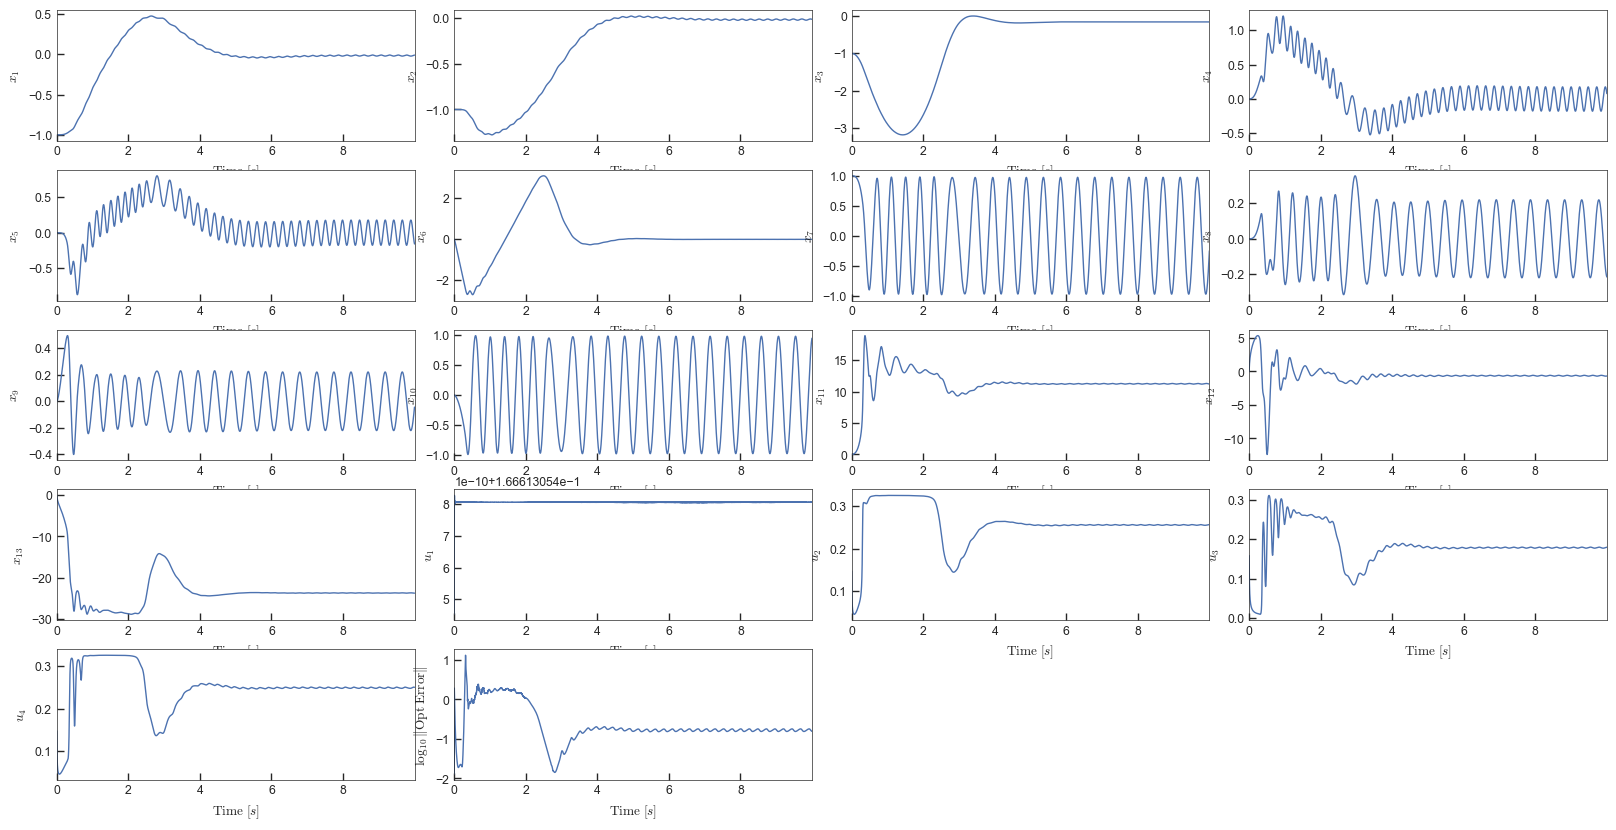

In [10]:
plotter = Plotter(log_dir=LGdir, log_name=LGname)
#plotter.show()
plotter.save()